In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from scipy.optimize import minimize
from datetime import timedelta

C:\Users\hp952\AppData\Local\Temp\ipykernel_17924\3758052575.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data = pd.read_csv('C:/Users/hp952/KaggleProject/NVDA - Copy.csv',parse_dates=['Date'],index_col='Date')


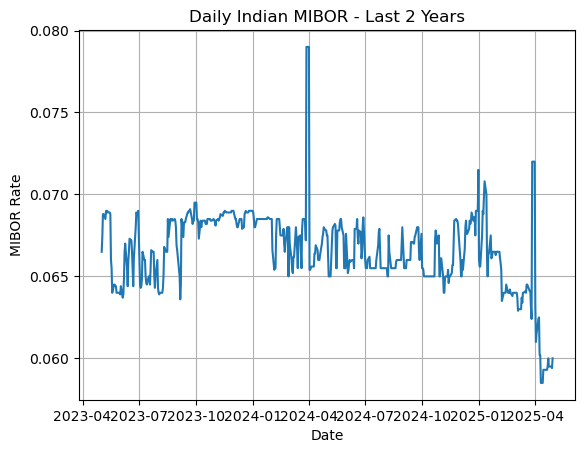

In [14]:
data = pd.read_csv('C:/Users/hp952/KaggleProject/NVDA - Copy.csv',parse_dates=['Date'],index_col='Date')
data = data.resample('B').ffill().dropna()
rates = data['MIBOR'] / 100
plt.plot(rates)
plt.title("Daily Indian MIBOR - Last 2 Years")
plt.xlabel("Date")
plt.ylabel("MIBOR Rate")
plt.grid(True)
plt.show()

In [4]:
dt = 1/252
r_t = rates[:-1].values
r_t1 = rates[1:].values
delta_r = r_t1 - r_t

#Linear Regression for vasicek: dr = a(b -r)dt + sigma*sqrt(dt)*N(0,1)
X = r_t.reshape(-1,1)
Y = delta_r / dt

from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X, Y)

a_hat = -reg.coef_[0]
b_hat = reg.intercept_ / a_hat
residuals = Y - reg.predict(X)
sigma_hat = np.std(residuals) * np.sqrt(252)

print(f"a = {a_hat:.4f}, b = {b_hat:.4f}, sigma = {sigma_hat:.4f}")

a = 36.6136, b = 0.0665, sigma = 5.0014


In [11]:
# Vasicek Model
def vasicek_bond_price(r, a, b, sigma, T):
    B = (1 - np.exp(-a * T)) / a
    A = np.exp((b - sigma**2 / (2*a**2)) * (B - T) - (sigma**2 * B**2) / (4 * a))
    return A * np.exp(-B * r)

maturities = [3.5, 4.5, 5.5]
prices_vasicek = [vasicek_bond_price(rates.iloc[-1], a_hat, b_hat, sigma_hat, T) for T in maturities]
yields_vasicek = [-np.log(p)/T for p, T in zip(prices_vasicek, maturities)]  

In [9]:
import QuantLib as ql

# Set up evaluation date
today = ql.Date().todaysDate()
ql.Settings.instance().evaluationDate = today

# Flat forward term structure using the last MIBOR rate
spot_rate = rates.iloc[-1]
flat_curve = ql.FlatForward(today, ql.QuoteHandle(ql.SimpleQuote(spot_rate)), ql.Actual365Fixed())
term_structure = ql.YieldTermStructureHandle(flat_curve)

# Hull-White model setup
hw_model = ql.HullWhite(term_structure)

# Bond pricing using Hull-White model
engine = ql.DiscountingBondEngine(term_structure)

# Create zero-coupon bonds for 3.5, 4.5, 5.5 years
maturities = [3.5, 4.5, 5.5]
bond_yields_hw = []

for T in maturities:
    maturity_date = today + ql.Period(int(T * 12 + 0.5), ql.Months)
    bond = ql.ZeroCouponBond(2, ql.India(), 100.0, maturity_date)
    bond.setPricingEngine(engine)
    
    price = bond.cleanPrice()
    yield_hw = -np.log(price / 100.0) / T  # Zero-coupon yield
    bond_yields_hw.append(yield_hw)


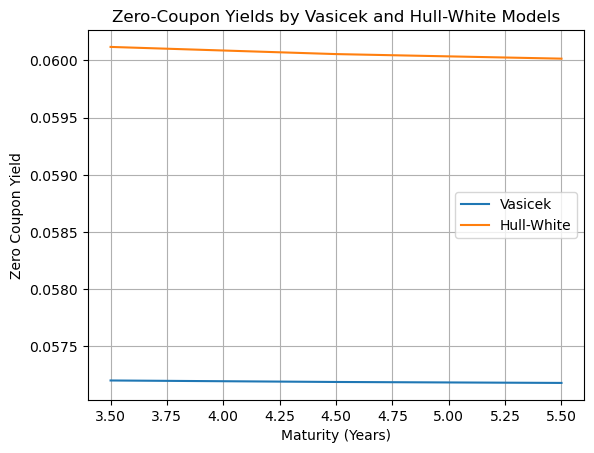

In [12]:
plt.plot(maturities, yields_vasicek, label='Vasicek')
plt.plot(maturities, bond_yields_hw, label='Hull-White')
plt.xlabel("Maturity (Years)")
plt.ylabel("Zero Coupon Yield")
plt.title("Zero-Coupon Yields by Vasicek and Hull-White Models")
plt.legend()
plt.grid(True)
plt.show()
